# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans

# EDA

In [4]:
# Load the data
#data = pd.read_excel(r'/Users/prithvishams/Documents/Bootcamp Concordia/M2P12-Classification_Project-main/churn.xlsx')
data = pd.read_excel('churn.xlsx')

<u>Country</u> and <u>State</u> all have a single value, hence these can be dropped <br>
Billing method and paper/paperless billing have no influence on customer retention, hence dropping these columns <br>
<u>Total Charges</u> column makes <u>Monthly Charges</u> column redundant <br>
<u>Churn Value</u> makes <u>Churn Label</u> redundant <br>
<u>Churn Reason</u> column has 6000 + missing values in a dataset of 7000 datapoints, hence, dropping this column.<br>
<br>
We will transform lat and lon data into a categorical column, so <u>zip code</u> is redundant location information.


In [6]:
# Drop unnecessary columns
df = data.drop(['CustomerID','Count','Country','State','City','Lat Long','Zip Code','Paperless Billing','Payment Method','Monthly Charges','Churn Label','Churn Reason'], axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Latitude           7043 non-null   float64
 1   Longitude          7043 non-null   float64
 2   Gender             7043 non-null   object 
 3   Senior Citizen     7043 non-null   object 
 4   Partner            7043 non-null   object 
 5   Dependents         7043 non-null   object 
 6   Tenure Months      7043 non-null   int64  
 7   Phone Service      7043 non-null   object 
 8   Multiple Lines     7043 non-null   object 
 9   Internet Service   7043 non-null   object 
 10  Online Security    7043 non-null   object 
 11  Online Backup      7043 non-null   object 
 12  Device Protection  7043 non-null   object 
 13  Tech Support       7043 non-null   object 
 14  Streaming TV       7043 non-null   object 
 15  Streaming Movies   7043 non-null   object 
 16  Contract           7043 

## Data Preprocessing

<b>Multiple Lines</b><br>
Indicates whether the customer subscribes to multiple telephone lines with the company. This column should contain yes/no values. <br>
<i>No phone service</i> shall be standardized to <i>no</i><br>
<br>
Similar cleanup is done in other columns where the customer did not subscribe to the specific service simply because they were not signed up for the internet service.

In [10]:
df['Multiple Lines']=df['Multiple Lines'].replace('No phone service','No')
df['Online Security']=df['Online Security'].replace('No internet service','No')
df['Online Backup']=df['Online Backup'].replace('No internet service','No')
df['Device Protection']=df['Device Protection'].replace('No internet service','No')
df['Tech Support']=df['Tech Support'].replace('No internet service','No')
df['Streaming TV']=df['Streaming TV'].replace('No internet service','No')
df['Streaming Movies']=df['Streaming Movies'].replace('No internet service','No')

<b>Convert object to float</b><br>
<u>Total Charges</u> should be float instead of object

In [12]:
#Convert object data type to float
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Total Charges'] = df['Total Charges'].astype(float)
df.dropna(subset=['Total Charges'], inplace=True) #drop 11 rows with missing values

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Latitude           7032 non-null   float64
 1   Longitude          7032 non-null   float64
 2   Gender             7032 non-null   object 
 3   Senior Citizen     7032 non-null   object 
 4   Partner            7032 non-null   object 
 5   Dependents         7032 non-null   object 
 6   Tenure Months      7032 non-null   int64  
 7   Phone Service      7032 non-null   object 
 8   Multiple Lines     7032 non-null   object 
 9   Internet Service   7032 non-null   object 
 10  Online Security    7032 non-null   object 
 11  Online Backup      7032 non-null   object 
 12  Device Protection  7032 non-null   object 
 13  Tech Support       7032 non-null   object 
 14  Streaming TV       7032 non-null   object 
 15  Streaming Movies   7032 non-null   object 
 16  Contract           7032 non-n

## Feature Engineering

### Encoding Geographic data with K-means clustering<br>
We will use Elbow method to find the optimal value of K <br>
Statistical literature recommends a range of 1 to 10 of K values for customer behavior modelling

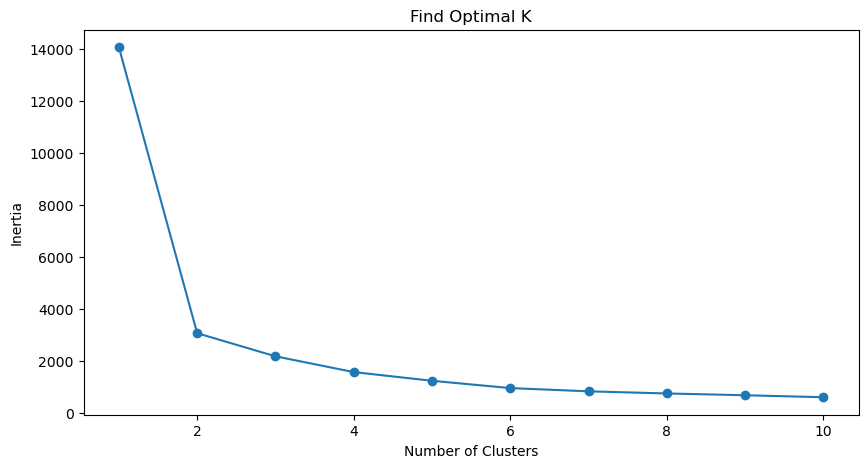

In [16]:
#standardize coordinates to mitigate scale difference between latitude (-90, +90) and longitude (-180, +180)
latlon_scaler = StandardScaler()

scaled_coords = latlon_scaler.fit_transform(df[['Latitude','Longitude']])

inertia = [] #list to store the values of inertia for elbow method plot

for k in range(1,11):
    kmeans = KMeans(n_clusters = k, n_init=10, random_state=42)
    kmeans.fit(scaled_coords)
    inertia.append(kmeans.inertia_)
#Visualize the elbow method
plt.figure(figsize=(10,5))
plt.plot(range(1,11), inertia, marker='o')
plt.title('Find Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

The elbow is observed at K = 2

In [18]:
#Train KMeans with the optimum K
kmeans_final = KMeans(n_clusters = 2, n_init=10, random_state=42)
df['Geo Cluster'] = kmeans_final.fit_predict(scaled_coords)
df['Geo Cluster'].value_counts()

Geo Cluster
1    3524
0    3508
Name: count, dtype: int64

All the location data points were grouped into 2 clusters with equal weights. Apparently, geolocation data may not have any impact on predicitng churn values. We will still retain this column for comparison and drop the rest of the geolocation features

In [20]:
df=df.drop(['Latitude','Longitude'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7032 non-null   object 
 1   Senior Citizen     7032 non-null   object 
 2   Partner            7032 non-null   object 
 3   Dependents         7032 non-null   object 
 4   Tenure Months      7032 non-null   int64  
 5   Phone Service      7032 non-null   object 
 6   Multiple Lines     7032 non-null   object 
 7   Internet Service   7032 non-null   object 
 8   Online Security    7032 non-null   object 
 9   Online Backup      7032 non-null   object 
 10  Device Protection  7032 non-null   object 
 11  Tech Support       7032 non-null   object 
 12  Streaming TV       7032 non-null   object 
 13  Streaming Movies   7032 non-null   object 
 14  Contract           7032 non-null   object 
 15  Total Charges      7032 non-null   float64
 16  Churn Value        7032 non-n

### Visualize correlation data<br>
Let's look at the correlation between churn value and the numerical features in the dataset

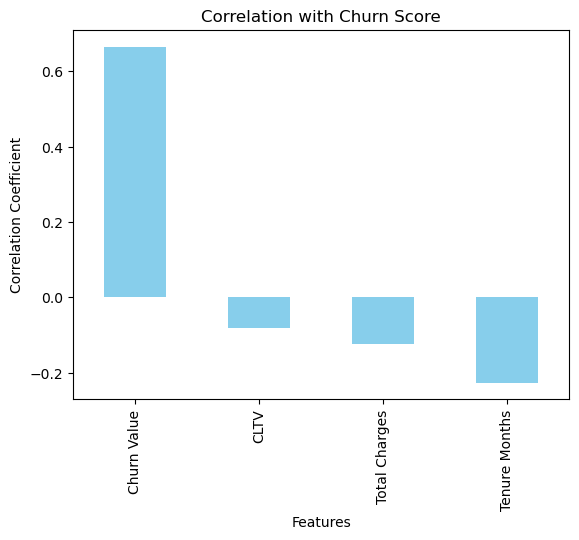

In [22]:
#Calculate correlation matrix
correlation_matrix = df[['Tenure Months','Total Charges','Churn Value','Churn Score','CLTV']].corr()
correlation_with_churn = correlation_matrix["Churn Score"].drop("Churn Score").sort_values(ascending=False) 

correlation_with_churn.plot(kind='bar', color='skyblue')
plt.title('Correlation with Churn Score')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.show()

The figure shows a strong correlation with churn value but a strong negative correlation with tenure, which is expected. According to the figure, the longer the customer stays with the company, the unlikely they are to churn.

### Encoding nominal categories

In [25]:
nominal_cols = ['Gender','Senior Citizen','Partner','Dependents','Phone Service','Multiple Lines','Internet Service','Online Security','Online Backup','Device Protection','Tech Support','Streaming TV','Streaming Movies']

nominal_encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded_nominal_cols_df = pd.DataFrame(nominal_encoder.fit_transform(df[nominal_cols]), columns=nominal_encoder.get_feature_names_out(nominal_cols))

encoded_nominal_cols_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender_Male                   7032 non-null   float64
 1   Senior Citizen_Yes            7032 non-null   float64
 2   Partner_Yes                   7032 non-null   float64
 3   Dependents_Yes                7032 non-null   float64
 4   Phone Service_Yes             7032 non-null   float64
 5   Multiple Lines_Yes            7032 non-null   float64
 6   Internet Service_Fiber optic  7032 non-null   float64
 7   Internet Service_No           7032 non-null   float64
 8   Online Security_Yes           7032 non-null   float64
 9   Online Backup_Yes             7032 non-null   float64
 10  Device Protection_Yes         7032 non-null   float64
 11  Tech Support_Yes              7032 non-null   float64
 12  Streaming TV_Yes              7032 non-null   float64
 13  Str

In [26]:
# drop original nominal features and add encoded nominal features
encoded_df = df.drop(nominal_cols, axis=1).join(encoded_nominal_cols_df)

### Encoding Ordinal Category

The only ordinal category in the dataset is <u>Contract</u> <br>
These categorical values are encoded on the assumption that companes place a higher weight on long-term contracts than month-to-month contracts.

In [29]:
order = ['Month-to-month','One year','Two year']
ordinal_encoder = OrdinalEncoder(categories=[order])
encoded_df['Contract_encoded'] = ordinal_encoder.fit_transform(df[['Contract']])
encoded_df.drop('Contract', axis=1, inplace=True)
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Tenure Months                 7032 non-null   int64  
 1   Total Charges                 7032 non-null   float64
 2   Churn Value                   7032 non-null   int64  
 3   Churn Score                   7032 non-null   int64  
 4   CLTV                          7032 non-null   int64  
 5   Geo Cluster                   7032 non-null   int32  
 6   Gender_Male                   7021 non-null   float64
 7   Senior Citizen_Yes            7021 non-null   float64
 8   Partner_Yes                   7021 non-null   float64
 9   Dependents_Yes                7021 non-null   float64
 10  Phone Service_Yes             7021 non-null   float64
 11  Multiple Lines_Yes            7021 non-null   float64
 12  Internet Service_Fiber optic  7021 non-null   float64
 13  Internet

In [30]:
#Drop null values after ordinal encoding
encoded_df.dropna(inplace=True)
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7021 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Tenure Months                 7021 non-null   int64  
 1   Total Charges                 7021 non-null   float64
 2   Churn Value                   7021 non-null   int64  
 3   Churn Score                   7021 non-null   int64  
 4   CLTV                          7021 non-null   int64  
 5   Geo Cluster                   7021 non-null   int32  
 6   Gender_Male                   7021 non-null   float64
 7   Senior Citizen_Yes            7021 non-null   float64
 8   Partner_Yes                   7021 non-null   float64
 9   Dependents_Yes                7021 non-null   float64
 10  Phone Service_Yes             7021 non-null   float64
 11  Multiple Lines_Yes            7021 non-null   float64
 12  Internet Service_Fiber optic  7021 non-null   float64
 13  Internet

In [31]:
encoded_df.to_csv("example df.csv", index=False)


## Visualizations

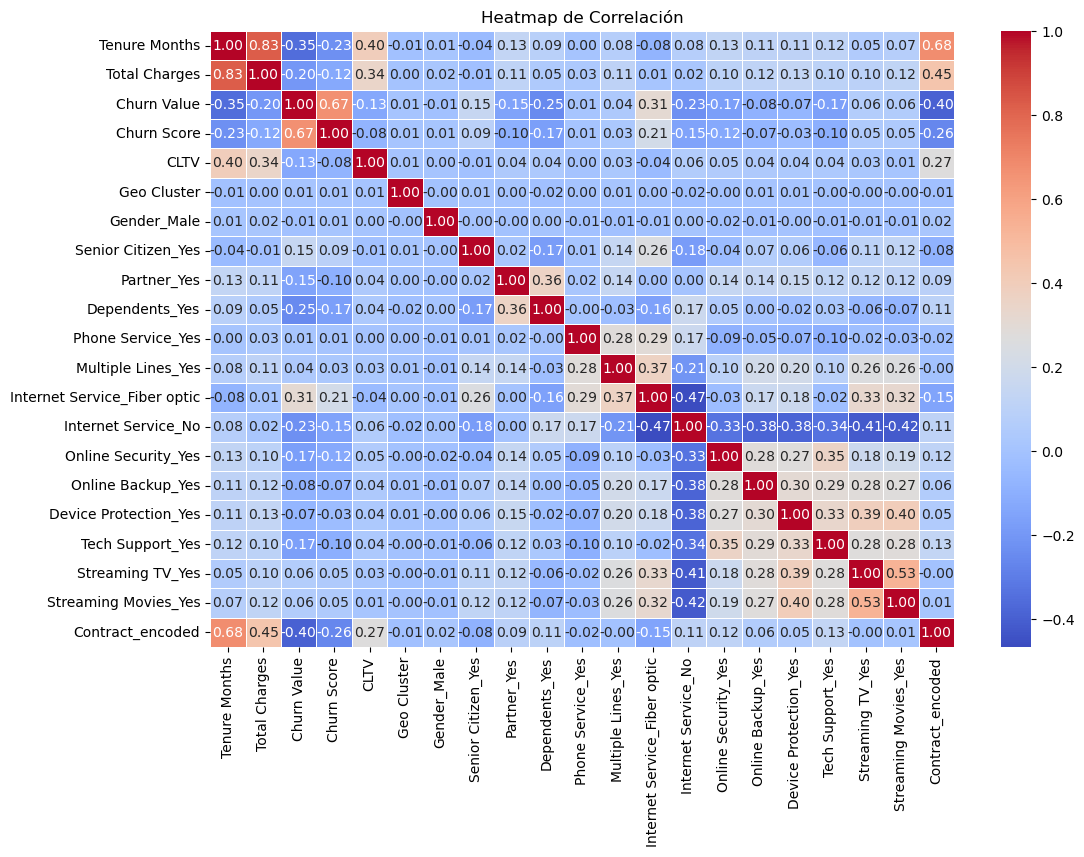

In [33]:
# Correlation HeatMap
corr_matrix = encoded_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap de Correlación")
plt.show()


In [34]:
# Print Churn Value correlation top 10
corr_pairs = corr_matrix.unstack()

# Delete correlation column with itself - Values 0 and 1
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

top_10_corr = corr_pairs.abs().sort_values(ascending=False).head(10)

print(top_10_corr)

Tenure Months                 Total Charges                   0.825941
Total Charges                 Tenure Months                   0.825941
Contract_encoded              Tenure Months                   0.676615
Tenure Months                 Contract_encoded                0.676615
Churn Value                   Churn Score                     0.665357
Churn Score                   Churn Value                     0.665357
Streaming Movies_Yes          Streaming TV_Yes                0.533206
Streaming TV_Yes              Streaming Movies_Yes            0.533206
Internet Service_No           Internet Service_Fiber optic    0.465398
Internet Service_Fiber optic  Internet Service_No             0.465398
dtype: float64


In [35]:
#Churn Value correlation with other columns descencing
churn_corr = corr_matrix["Churn Value"].sort_values(ascending=False)

print(churn_corr)

Churn Value                     1.000000
Churn Score                     0.665357
Internet Service_Fiber optic    0.307819
Senior Citizen_Yes              0.150477
Streaming TV_Yes                0.063642
Streaming Movies_Yes            0.060876
Multiple Lines_Yes              0.040138
Phone Service_Yes               0.012004
Geo Cluster                     0.007628
Gender_Male                    -0.008477
Device Protection_Yes          -0.066399
Online Backup_Yes              -0.082532
CLTV                           -0.128586
Partner_Yes                    -0.150705
Tech Support_Yes               -0.165088
Online Security_Yes            -0.171806
Total Charges                  -0.199669
Internet Service_No            -0.227570
Dependents_Yes                 -0.248635
Tenure Months                  -0.354395
Contract_encoded               -0.396470
Name: Churn Value, dtype: float64


### Strong positive relation
- Churn Score (+0.66) -  a higher Churn Score indicates a higher churn.
- Internet Service_Fiber optic (+0.31) - Customers with fiber optic internet churn more. This could be due to higher costs or service issues.

### Strong negative relation
- Contract_encoded (-0.40) - Customers with long contracts churn less.
- Tenure Months (-0.35) -  The longer a customer stays, the less probably they will churn. 
- Dependents_Yes (-0.25) - Customers with dependents are less likely to churn, possibly because their families rely on the service, or loosing the service has a negative impact 
- Internet Service_No (-0.23) - Those who do not have internet churn less
- Total Charges (-0.20) - Higher total spending is linked to lower churn ??? 

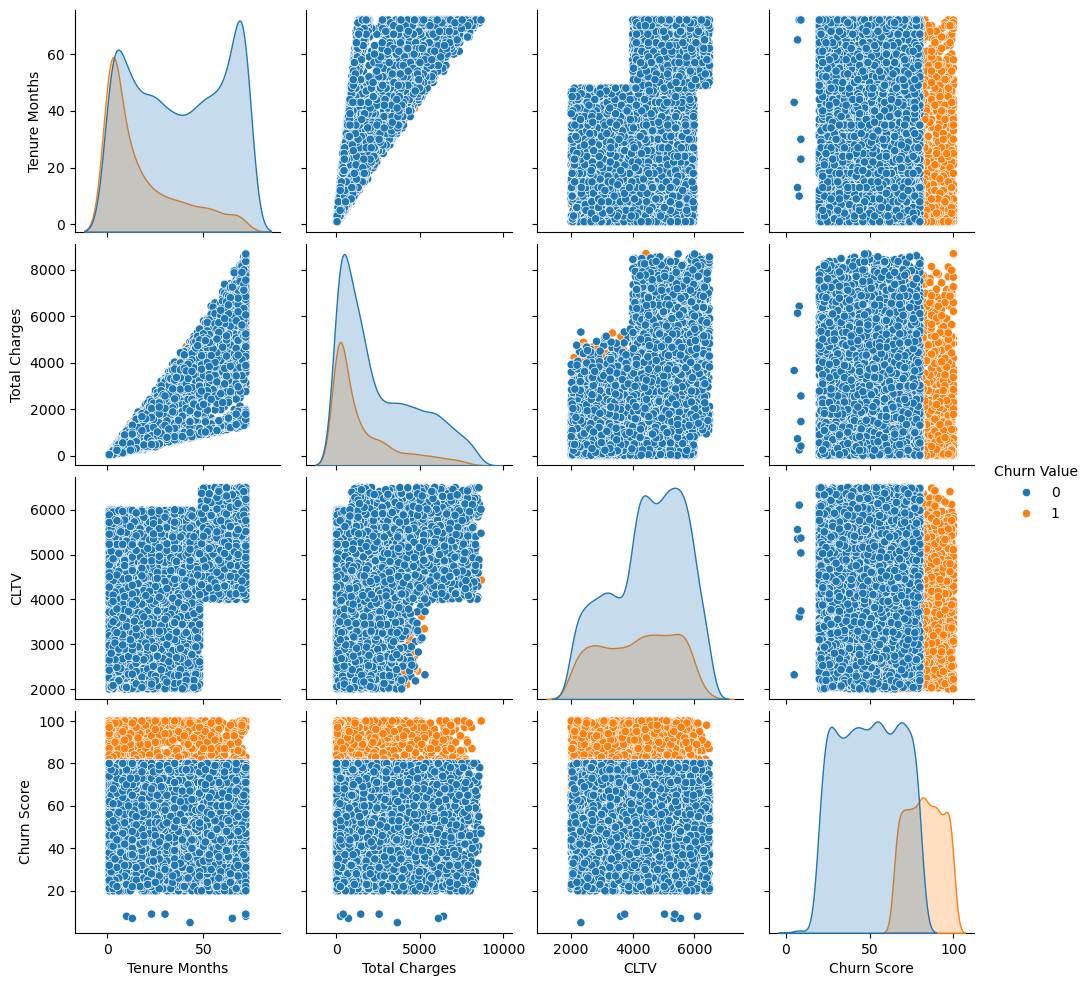

In [37]:
# Checking relation between between columns
sns.pairplot(encoded_df[["Tenure Months", "Total Charges", "Churn Value", "CLTV", "Churn Score"]], hue="Churn Value")
plt.show()


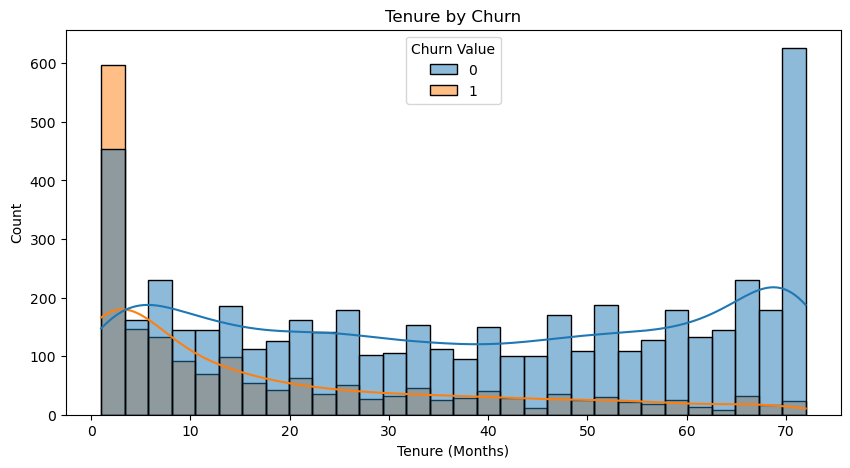

In [38]:
#Checking Tenure Months vs Churn Value
plt.figure(figsize=(10, 5))
sns.histplot(data=encoded_df, x="Tenure Months", hue="Churn Value", kde=True, bins=30, palette=["#1f77b4", "#ff7f0e"])
plt.xlabel("Tenure (Months)")
plt.ylabel("Count")
plt.title("Tenure by Churn")
plt.show()

#### The less time as a client, the less commitment, the more churn probability
#### The more time as a client, the more commitment, the less churn probability

## Random Forest Classification Model

In [41]:
# Setting up this model
# Seperate X and y
X = encoded_df.drop(['Churn Value'],axis=1)
y = encoded_df['Churn Value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42) # This allows for it to be reporduced  

# I ran various different instances of the data and concluded that a test size of 0.22 produced the highest accurary, although 
# the differences were very minor.

# Scalar Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

After the test size was decided - the number of decision trees needed to be chosen. Due to this being a smaller dataset, it is possible it iterate over a number of different decision trees to compare cross validation score with a focus on the Mean Accuracy.

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# How many states should be looked at? Large numbers take a lot of processing power  
random_states = range(100, 401, 50)  # Testing random states from 100 to 400 in steps of 50

results = []

for state in random_states:
    # Initialize Random Forest with a specific random state
    test_rfc = RandomForestClassifier(random_state=state)
    
    # Perform cross-validation 
    scores = cross_val_score(test_rfc, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    # Store mean accuracy for the current random state
    mean_accuracy = np.mean(scores)
    results.append((state, mean_accuracy))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Random State', 'Mean Accuracy'])

print(results_df.sort_values(by='Mean Accuracy', ascending=False))

   Random State  Mean Accuracy
1           150       0.954346
2           200       0.953980
6           400       0.953067
0           100       0.952702
3           250       0.952519
4           300       0.951789
5           350       0.951241


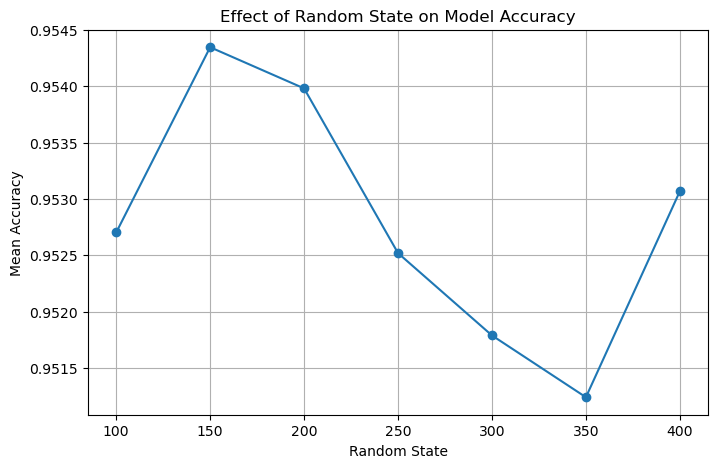

In [44]:
#plotting this out for a visual
plt.figure(figsize=(8, 5))
plt.plot(results_df['Random State'], results_df['Mean Accuracy'], marker='o', linestyle='-')
plt.xlabel('Random State')
plt.ylabel('Mean Accuracy')
plt.title('Effect of Random State on Model Accuracy')
plt.grid(True)
plt.show()

Seems that 150 decision trees produces the best results with 200 almost identical.

In [46]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=150)


In [47]:
# Fit  model
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=150)

In [48]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred = rfc.predict(X_test)
rfc_cm = confusion_matrix(y_test, y_pred)

print(rfc_cm)

[[1070   36]
 [  39  400]]


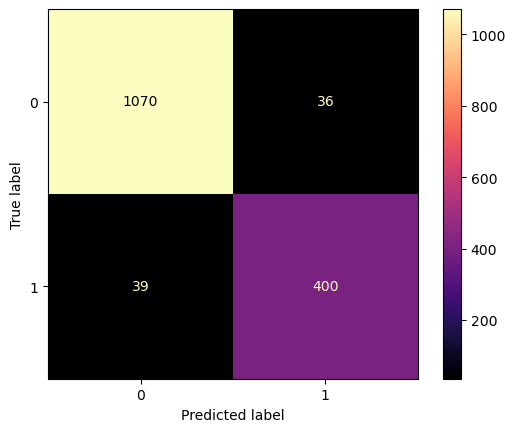

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(rfc_cm, display_labels=rfc.classes_)
disp.plot(cmap="magma")
plt.show()

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1106
           1       0.92      0.91      0.91       439

    accuracy                           0.95      1545
   macro avg       0.94      0.94      0.94      1545
weighted avg       0.95      0.95      0.95      1545



In [51]:
y_pred = rfc.predict(X_test)

print('Model accuracy score with 150 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 150 decision-trees : 0.9515


Value 0 (no Churn)
- Precision = 96% of the time when the model predicted No Churn, it was correct.
- Recall    = 97% of the No Churn cases were correctly identified.

Value 1 (Churn)
- Precision = 92% of the time when the model predicted Churn, it was correct.
- Recall    = 91% of the Churn cases were correctly identified.

## Random Forest Classification Model Using Selected Features

This finds the non-linear relationships between features and ranks them on how impoartant they are to the target of the model.

In [54]:
#lets find the feature scores based off the model with 200 decision trees

feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(feature_scores)

Churn Score                     0.486591
Tenure Months                   0.091231
Total Charges                   0.082211
Contract_encoded                0.074814
CLTV                            0.046203
Internet Service_Fiber optic    0.044739
Dependents_Yes                  0.026495
Internet Service_No             0.019085
Partner_Yes                     0.016683
Tech Support_Yes                0.016163
Online Security_Yes             0.014416
Online Backup_Yes               0.013346
Multiple Lines_Yes              0.010335
Device Protection_Yes           0.010194
Geo Cluster                     0.009266
Streaming TV_Yes                0.009265
Streaming Movies_Yes            0.008533
Gender_Male                     0.008261
Senior Citizen_Yes              0.008121
Phone Service_Yes               0.004048
dtype: float64


C:\Users\Jon\AppData\Local\Temp\ipykernel_21028\348222554.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_scores.values, y=feature_scores.index, palette="magma")


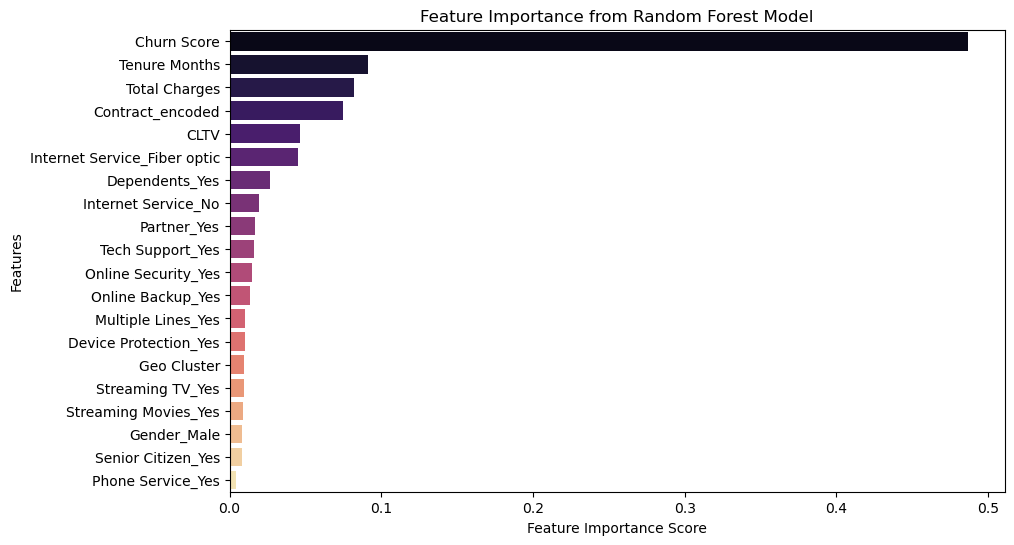

In [55]:
# Sorting feature importance values
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_scores.values, y=feature_scores.index, palette="magma")

# Plot for easy visuals
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest Model")
plt.show()

In [56]:
#Lets try to drop some of the less important features 
# Seperate X and y
X = encoded_df.drop(['Churn Value', 'Phone Service_Yes', 'Senior Citizen_Yes',
                     'Gender_Male', 'Streaming TV_Yes', 'Streaming Movies_Yes', 'Geo Cluster' ],axis=1)

y = encoded_df['Churn Value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42) #This allows for it top be reporduced  

# Scalar Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
#New mondel using less features
Dropped_rfc = RandomForestClassifier(n_estimators=150)
# Fit model
Dropped_rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150)

In [58]:
# Evaluate new model with dropped features
y_pred_Dropped_rfc = Dropped_rfc.predict(X_test)
Dropped_rfc_cm = confusion_matrix(y_test, y_pred_Dropped_rfc)

print(Dropped_rfc_cm)

[[1072   34]
 [  42  397]]


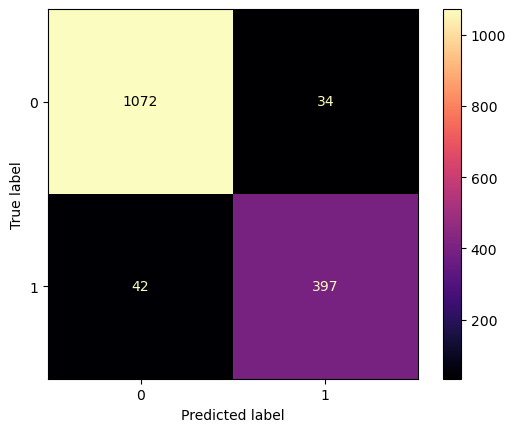

In [59]:
disp = ConfusionMatrixDisplay(Dropped_rfc_cm, display_labels=rfc.classes_)
disp.plot(cmap="magma")
plt.show()

In [60]:
print(classification_report(y_test, y_pred_Dropped_rfc))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1106
           1       0.92      0.90      0.91       439

    accuracy                           0.95      1545
   macro avg       0.94      0.94      0.94      1545
weighted avg       0.95      0.95      0.95      1545



In [61]:
print('Model accuracy score with 150 decision-trees and Selected Features : {0:0.4f}'. format(accuracy_score(y_test, y_pred_Dropped_rfc)))

Model accuracy score with 150 decision-trees and Selected Features : 0.9508


This does not appear to change the model accuracy any tangable amount which makes sense. 
The key is to find a balance between removing irrelevant features to increase efficiency of the model and using the correct number of decision trees without sacrificing training speed.
Removing features would be more effective if the data set being used is massive  

## Testing Final Model with Simulated Inputs

Using some simulated data that follows our encoded df - lets see how the model reacts.

In [65]:
sample_encoded_df = pd.read_csv("sample_encoded_df.csv")
sample_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Tenure Months                 4999 non-null   int64
 1   Total Charges                 4999 non-null   int64
 2   Churn Value                   4999 non-null   int64
 3   Churn Score                   4999 non-null   int64
 4   CLTV                          4999 non-null   int64
 5   Geo Cluster                   4999 non-null   int64
 6   Gender_Male                   4999 non-null   int64
 7   Senior Citizen_Yes            4999 non-null   int64
 8   Partner_Yes                   4999 non-null   int64
 9   Dependents_Yes                4999 non-null   int64
 10  Phone Service_Yes             4999 non-null   int64
 11  Multiple Lines_Yes            4999 non-null   int64
 12  Internet Service_Fiber optic  4999 non-null   int64
 13  Internet Service_No           499

In [66]:
sample_encoded_df.sample(5)

,Tenure Months,Total Charges,Churn Value,Churn Score,CLTV,Geo Cluster,Gender_Male,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,...,Multiple Lines_Yes,Internet Service_Fiber optic,Internet Service_No,Online Security_Yes,Online Backup_Yes,Device Protection_Yes,Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Contract_encoded
3081,19,4121,0,74,4927,1,1,0,0,1,...,0,0,1,1,1,0,0,0,0,0
4627,34,1343,0,22,2423,0,1,0,0,0,...,0,1,0,1,1,1,1,1,1,0
104,4,2893,1,54,2830,1,1,0,0,1,...,1,0,1,0,1,0,1,1,0,0
1226,25,4296,1,53,5259,1,1,1,1,0,...,0,1,0,1,0,1,0,1,1,1
2850,58,3627,0,80,2454,0,1,1,0,1,...,0,1,0,0,0,0,1,0,1,0


In [67]:
# Seperate X and y
X = sample_encoded_df.drop(['Churn Value'],axis=1)
y = sample_encoded_df['Churn Value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42) # This allows for it to be reporduced  


# Scalar Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
sample_rfc = RandomForestClassifier(n_estimators=150)
# Fit  model
sample_rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150)

In [69]:
# Confusion Matrix
sample_y_pred = sample_rfc.predict(X_test)
sample_rfc_cm = confusion_matrix(y_test, sample_y_pred)

print(sample_rfc_cm)

[[510  31]
 [ 38 521]]


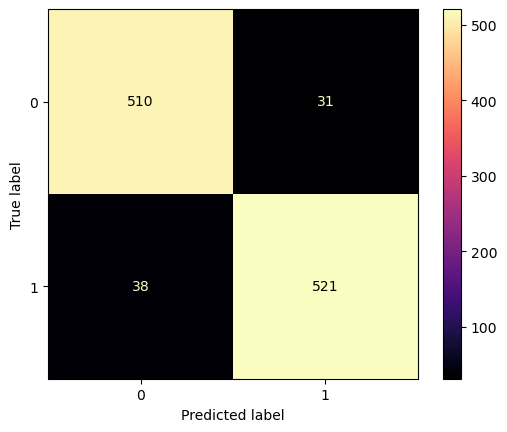

In [70]:

disp = ConfusionMatrixDisplay(sample_rfc_cm, display_labels=rfc.classes_)
disp.plot(cmap="magma")
plt.show()

In [71]:
print(classification_report(y_test, sample_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       541
           1       0.94      0.93      0.94       559

    accuracy                           0.94      1100
   macro avg       0.94      0.94      0.94      1100
weighted avg       0.94      0.94      0.94      1100



In [72]:
print('Model accuracy score with 150 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, sample_y_pred)))

Model accuracy score with 150 decision-trees : 0.9373


Results: The model is still accurate but this is only based on the semi-random simulated data that was created.